## Bayesian AGN Decomposition Analysis for SDSS Spectra (BADASS)
### Single Spectrum

####  Remington O. Sexton$^{1,2}$, Sara M. Doan$^{1}$, Michael A. Reefe$^{1}$, William Matzko$^{1}$
$^{1}$George Mason University, $^{2}$United States Naval Observatory


In [1]:
import glob
import time
import natsort
from IPython.display import clear_output
# import multiprocess as mp
import os
import psutil
import pathlib
import natsort
# Import BADASS here
import badass as badass
import badass_utils as badass_utils
import badass_ncomp_options

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### BADASS Options

In [2]:
options_file = "badass_ncomp_options.py"
if os.path.exists(options_file):
    print("\n Options file %s found.\n" % (options_file))


 Options file badass_ncomp_options.py found.



### Run BADASS on a single spectrum

The following is shows how to fit single SDSS spectra.

#### Directory Structure

In [3]:
nobj = 8 # Object in the spec_dir list
########################## Directory Structure #################################
spec_dir = 'examples/' # folder with spectra in it
# Get full list of spectrum folders; these will be the working directories
spec_loc = natsort.natsorted( glob.glob(spec_dir+'*') )[nobj]

################################################################################
print(len(spec_loc))
print(spec_loc)


15
examples/8-test


#### Choose Spectrum 

In [4]:
file = glob.glob(spec_loc+'/*.fits')[0] # Get name of FITS spectra file
print(file)

examples/8-test/spec-1701-53142-0483.fits


#### Run IRSA Dust Query
To correct for Galactic extinction.  This only needs to be done once so that the data is stored locally.

In [5]:
# badass_utils.fetch_IRSA_dust(spec_loc)

#### Run 

Start process memory: 0.52276838                    
 Storing MCMC_output in examples/8-test/MCMC_output_11/

 > Starting fit for 8-test


-----------------------------------------------------------
 file:                        spec-1701-53142-0483.fits     
 SDSS redshift:               0.12047                       
 fitting region:              (4400,5500) [A]               
 velocity scale:              68.97 [km/s/pixel]            
 Galactic E(B-V):             0.025                         
 Flux Normalization:          1.0e-17                       
-----------------------------------------------------------
	 - Adding parameter for unexplained noise to fit reduced Chi-squared.
	 - Fitting a SSP host-galaxy template.
  - Fitting additive legendre polynomial component.
	 - Fitting Simple AGN power-law continuum.
	 - Fitting broad and narrow optical FeII using Veron-Cetty et al. (2004) optical FeII templates
	 		* varying optical FeII amplitudes
	 		* varying optical FeII disper

basinhopping step 17: f -20.2766 trial_f 358.9 accepted 0  lowest_f -20.2766
-20.276649358085052 1
at minimum 358.9002 accepted 0
 Fit Status: False
 Force threshold: 161.19
 Lowest RMSE: 48.68
 Current RMSE: 278.11
 RMSE MAD: 0.45
 RMSE STD: 0.72
 Accepted count: 6
 Basinhop count: 2




basinhopping step 18: f -20.2766 trial_f 284.743 accepted 0  lowest_f -20.2766
-20.276649358085052 2
at minimum 284.7428 accepted 0
 Fit Status: False
 Force threshold: 161.19
 Lowest RMSE: 48.68
 Current RMSE: 177.15
 RMSE MAD: 0.45
 RMSE STD: 0.72
 Accepted count: 6
 Basinhop count: 3




basinhopping step 19: f -20.2766 trial_f -15.6941 accepted 0  lowest_f -20.2766
-20.276649358085052 3
at minimum -15.6941 accepted 0
 Fit Status: False
 Force threshold: 161.19
 Lowest RMSE: 48.68
 Current RMSE: 49.74
 RMSE MAD: 0.62
 RMSE STD: 0.66
 Accepted count: 6
 Basinhop count: 4




basinhopping step 20: f -20.2766 trial_f inf accepted 0  lowest_f -20.2766
-20.276649358085052 4
at minimum inf accepted 0
 Fi

basinhopping step 41: f -29.2239 trial_f -11.5601 accepted 0  lowest_f -29.2239
-29.223927334421127 3
at minimum -11.5601 accepted 0
 Fit Status: False
 Force threshold: 161.19
 Lowest RMSE: 46.32
 Current RMSE: 50.60
 RMSE MAD: 1.18
 RMSE STD: 3.97
 Accepted count: 12
 Basinhop count: 4




basinhopping step 42: f -29.2239 trial_f inf accepted 0  lowest_f -29.2239
-29.223927334421127 4
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 161.19
 Lowest RMSE: 46.32
 Current RMSE: 274.04
 RMSE MAD: 1.18
 RMSE STD: 3.97
 Accepted count: 12
 Basinhop count: 5




basinhopping step 43: f -29.2239 trial_f -26.0383 accepted 0  lowest_f -29.2239
-29.223927334421127 5
at minimum -26.0383 accepted 0
 Fit Status: False
 Force threshold: 161.19
 Lowest RMSE: 46.32
 Current RMSE: 47.26
 RMSE MAD: 1.06
 RMSE STD: 3.87
 Accepted count: 12
 Basinhop count: 6




basinhopping step 44: f -29.2239 trial_f -26.0389 accepted 0  lowest_f -29.2239
-29.223927334421127 6
at minimum -26.0389 accepted



NA_OIII_4960
	 center = 4960.295
	 amp = (NA_OIII_5007_AMP/2.98)
	 disp = NA_OIII_5007_DISP
	 voff = NA_OIII_5007_VOFF
	 line_type = na
	 label = [O III]
	 ncomp = 1
	 line_profile = gaussian
	 center_pix = 53.09249465126236
	 disp_res_ang = 0.8870212540543747
	 disp_res_kms = 53.61017480839414
NA_OIII_5007
	 center = 5008.24
	 amp = free
	 disp = free
	 voff = free
	 line_type = na
	 label = [O III]
	 ncomp = 1
	 line_profile = gaussian
	 center_pix = 94.86880881729527
	 disp_res_ang = 0.8925869962336651
	 disp_res_kms = 53.43011708299267
NA_OIII_4960_2
	 center = 4960.295
	 amp = (NA_OIII_5007_2_AMP/2.98)
	 disp = NA_OIII_5007_2_DISP
	 voff = NA_OIII_5007_2_VOFF
	 line_type = na
	 ncomp = 2
	 parent = NA_OIII_4960
	 line_profile = gaussian
	 center_pix = 53.09249465126236
	 disp_res_ang = 0.8870212540543747
	 disp_res_kms = 53.61017480839414
NA_OIII_5007_2
	 center = 5008.24
	 amp = free
	 disp = free
	 voff = free
	 line_type = na
	 ncomp = 2
	 parent = NA_OIII_5007
	 line_profile

basinhopping step 21: f -112.505 trial_f -5.34319 accepted 0  lowest_f -112.505
-112.50475747487918 8
at minimum -5.3432 accepted 0
 Fit Status: False
 Force threshold: 46.32
 Lowest RMSE: 31.38
 Current RMSE: 50.69
 RMSE MAD: 0.63
 RMSE STD: 1.35
 Accepted count: 5
 Basinhop count: 9




basinhopping step 22: f -112.505 trial_f inf accepted 0  lowest_f -112.505
-112.50475747487918 9
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 46.32
 Lowest RMSE: 31.38
 Current RMSE: 161.71
 RMSE MAD: 0.63
 RMSE STD: 1.35
 Accepted count: 5
 Basinhop count: 10




basinhopping step 23: f -112.505 trial_f inf accepted 0  lowest_f -112.505
-112.50475747487918 10
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 46.32
 Lowest RMSE: 31.38
 Current RMSE: 272.12
 RMSE MAD: 0.63
 RMSE STD: 1.35
 Accepted count: 5
 Basinhop count: 11




basinhopping step 24: f -112.505 trial_f inf accepted 0  lowest_f -112.505
-112.50475747487918 11
at minimum inf accepted 0
 Fit Status: False


basinhopping step 46: f -113.941 trial_f inf accepted 0  lowest_f -113.941
-113.94100915975163 5
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 46.32
 Lowest RMSE: 31.08
 Current RMSE: 232.66
 RMSE MAD: 0.33
 RMSE STD: 5.03
 Accepted count: 11
 Basinhop count: 6




basinhopping step 47: f -113.941 trial_f inf accepted 0  lowest_f -113.941
-113.94100915975163 6
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 46.32
 Lowest RMSE: 31.08
 Current RMSE: 421.59
 RMSE MAD: 0.33
 RMSE STD: 5.03
 Accepted count: 11
 Basinhop count: 7




basinhopping step 48: f -113.941 trial_f -108.372 accepted 0  lowest_f -113.941
-113.94100915975163 7
at minimum -108.3719 accepted 0
 Fit Status: False
 Force threshold: 46.32
 Lowest RMSE: 31.08
 Current RMSE: 31.83
 RMSE MAD: 0.40
 RMSE STD: 4.91
 Accepted count: 11
 Basinhop count: 8




basinhopping step 49: f -113.941 trial_f inf accepted 0  lowest_f -113.941
-113.94100915975163 8
at minimum inf accepted 0
 Fit Status: False

basinhopping step 0: f 38.4536
inf 0
at minimum 38.4536 accepted 1
 Fit Status: False
 Force threshold: 31.17
 Lowest RMSE: inf
 Current RMSE: 55.27
 RMSE MAD: nan
 RMSE STD: nan
 Accepted count: 1
 Basinhop count: 0




basinhopping step 1: f 38.4536 trial_f 463.249 accepted 0  lowest_f 38.4536
38.45359147317668 0
at minimum 463.2493 accepted 0
 Fit Status: False
 Force threshold: 31.17
 Lowest RMSE: inf
 Current RMSE: 55.66
 RMSE MAD: nan
 RMSE STD: nan
 Accepted count: 1
 Basinhop count: 1




basinhopping step 2: f 38.4536 trial_f inf accepted 0  lowest_f 38.4536
38.45359147317668 1
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 31.17
 Lowest RMSE: inf
 Current RMSE: 205.48
 RMSE MAD: nan
 RMSE STD: nan
 Accepted count: 1
 Basinhop count: 2




basinhopping step 3: f -94.8417 trial_f -94.8417 accepted 1  lowest_f -94.8417
found new global minimum on step 3 with function value -94.8417
38.45359147317668 2
at minimum -94.8417 accepted 1
 Fit Status: False
 Force thres

basinhopping step 25: f -102.819 trial_f inf accepted 0  lowest_f -102.819
-102.8188327972707 2
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 31.17
 Lowest RMSE: 31.73
 Current RMSE: 652.87
 RMSE MAD: 0.00
 RMSE STD: 0.00
 Accepted count: 3
 Basinhop count: 3




basinhopping step 26: f -102.819 trial_f -96.8947 accepted 0  lowest_f -102.819
-102.8188327972707 3
at minimum -96.8947 accepted 0
 Fit Status: False
 Force threshold: 31.17
 Lowest RMSE: 31.73
 Current RMSE: 31.74
 RMSE MAD: 0.01
 RMSE STD: 0.01
 Accepted count: 3
 Basinhop count: 4




basinhopping step 27: f -102.819 trial_f -5.98219 accepted 0  lowest_f -102.819
-102.8188327972707 4
at minimum -5.9822 accepted 0
 Fit Status: False
 Force threshold: 31.17
 Lowest RMSE: 31.73
 Current RMSE: 47.63
 RMSE MAD: 0.01
 RMSE STD: 0.01
 Accepted count: 3
 Basinhop count: 5




basinhopping step 28: f -102.819 trial_f inf accepted 0  lowest_f -102.819
-102.8188327972707 5
at minimum inf accepted 0
 Fit Status: False

basinhopping step 50: f -198.762 trial_f -190.883 accepted 0  lowest_f -198.762
-198.7619724897038 18
at minimum -190.8833 accepted 0
 Fit Status: False
 Force threshold: 31.17
 Lowest RMSE: 16.29
 Current RMSE: 17.04
 RMSE MAD: 0.40
 RMSE STD: 7.27
 Accepted count: 5
 Basinhop count: 19




basinhopping step 51: f -198.762 trial_f 1.7416 accepted 0  lowest_f -198.762
-198.7619724897038 19
at minimum 1.7416 accepted 0
 Fit Status: False
 Force threshold: 31.17
 Lowest RMSE: 16.29
 Current RMSE: 43.90
 RMSE MAD: 0.40
 RMSE STD: 7.27
 Accepted count: 5
 Basinhop count: 20




basinhopping step 52: f -198.762 trial_f inf accepted 0  lowest_f -198.762
-198.7619724897038 20
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 31.17
 Lowest RMSE: 16.29
 Current RMSE: 203.61
 RMSE MAD: 0.40
 RMSE STD: 7.27
 Accepted count: 5
 Basinhop count: 21




basinhopping step 53: f -199.776 trial_f -199.776 accepted 1  lowest_f -199.776
found new global minimum on step 53 with function value 

basinhopping step 74: f -202.556 trial_f inf accepted 0  lowest_f -202.556
-202.5556188161538 15
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 31.17
 Lowest RMSE: 15.29
 Current RMSE: 351.59
 RMSE MAD: 0.83
 RMSE STD: 7.74
 Accepted count: 8
 Basinhop count: 16




basinhopping step 75: f -202.556 trial_f inf accepted 0  lowest_f -202.556
-202.5556188161538 16
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 31.17
 Lowest RMSE: 15.29
 Current RMSE: 168.99
 RMSE MAD: 0.83
 RMSE STD: 7.74
 Accepted count: 8
 Basinhop count: 17




basinhopping step 76: f -202.556 trial_f -186.63 accepted 0  lowest_f -202.556
-202.5556188161538 17
at minimum -186.6301 accepted 0
 Fit Status: False
 Force threshold: 31.17
 Lowest RMSE: 15.29
 Current RMSE: 16.95
 RMSE MAD: 7.61
 RMSE STD: 7.71
 Accepted count: 8
 Basinhop count: 18




basinhopping step 77: f -202.556 trial_f inf accepted 0  lowest_f -202.556
-202.5556188161538 18
at minimum inf accepted 0
 Fit Status: False


basinhopping step 6: f -106.814 trial_f inf accepted 0  lowest_f -106.814
-106.81425079104257 4
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 15.29
 Lowest RMSE: 25.28
 Current RMSE: 313.80
 RMSE MAD: nan
 RMSE STD: nan
 Accepted count: 2
 Basinhop count: 5




basinhopping step 7: f -154.688 trial_f -154.688 accepted 1  lowest_f -154.688
found new global minimum on step 7 with function value -154.688
-106.81425079104257 5
at minimum -154.6881 accepted 1
 Fit Status: False
 Force threshold: 15.29
 Lowest RMSE: 18.35
 Current RMSE: 18.35
 RMSE MAD: nan
 RMSE STD: nan
 Accepted count: 3
 Basinhop count: 0




basinhopping step 8: f -154.688 trial_f -21.243 accepted 0  lowest_f -154.688
-154.68809151483572 0
at minimum -21.2430 accepted 0
 Fit Status: False
 Force threshold: 15.29
 Lowest RMSE: 18.35
 Current RMSE: 45.97
 RMSE MAD: nan
 RMSE STD: nan
 Accepted count: 3
 Basinhop count: 1




basinhopping step 9: f -154.688 trial_f -28.2534 accepted 0  lowest_f -154.688
-1

basinhopping step 30: f -211.705 trial_f inf accepted 0  lowest_f -211.705
-211.70494210456656 3
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 15.29
 Lowest RMSE: 13.87
 Current RMSE: 260.71
 RMSE MAD: 1.07
 RMSE STD: 1.07
 Accepted count: 7
 Basinhop count: 4




basinhopping step 31: f -211.705 trial_f inf accepted 0  lowest_f -211.705
-211.70494210456656 4
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 15.29
 Lowest RMSE: 13.87
 Current RMSE: 348.53
 RMSE MAD: 1.07
 RMSE STD: 1.07
 Accepted count: 7
 Basinhop count: 5




basinhopping step 32: f -211.705 trial_f inf accepted 0  lowest_f -211.705
-211.70494210456656 5
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 15.29
 Lowest RMSE: 13.87
 Current RMSE: 372.52
 RMSE MAD: 1.07
 RMSE STD: 1.07
 Accepted count: 7
 Basinhop count: 6




basinhopping step 33: f -211.705 trial_f inf accepted 0  lowest_f -211.705
-211.70494210456656 6
at minimum inf accepted 0
 Fit Status: False
 Force thres

basinhopping step 0: f -102.69
inf 0
at minimum -102.6901 accepted 1
 Fit Status: False
 Force threshold: 13.87
 Lowest RMSE: inf
 Current RMSE: 30.15
 RMSE MAD: nan
 RMSE STD: nan
 Accepted count: 1
 Basinhop count: 0




basinhopping step 1: f -102.69 trial_f inf accepted 0  lowest_f -102.69
-102.69007780784185 0
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 13.87
 Lowest RMSE: inf
 Current RMSE: 267.14
 RMSE MAD: nan
 RMSE STD: nan
 Accepted count: 1
 Basinhop count: 1




basinhopping step 2: f -102.69 trial_f -23.1116 accepted 0  lowest_f -102.69
-102.69007780784185 1
at minimum -23.1116 accepted 0
 Fit Status: False
 Force threshold: 13.87
 Lowest RMSE: inf
 Current RMSE: 43.00
 RMSE MAD: nan
 RMSE STD: nan
 Accepted count: 1
 Basinhop count: 2




basinhopping step 3: f -120.665 trial_f -120.665 accepted 1  lowest_f -120.665
found new global minimum on step 3 with function value -120.665
-102.69007780784185 2
at minimum -120.6655 accepted 1
 Fit Status: False
 F

basinhopping step 25: f -189.426 trial_f inf accepted 0  lowest_f -189.426
-189.42592167177074 1
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 13.87
 Lowest RMSE: 15.18
 Current RMSE: 523.18
 RMSE MAD: nan
 RMSE STD: nan
 Accepted count: 4
 Basinhop count: 2




basinhopping step 26: f -189.426 trial_f inf accepted 0  lowest_f -189.426
-189.42592167177074 2
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 13.87
 Lowest RMSE: 15.18
 Current RMSE: 386.73
 RMSE MAD: nan
 RMSE STD: nan
 Accepted count: 4
 Basinhop count: 3




basinhopping step 27: f -189.426 trial_f -118.267 accepted 0  lowest_f -189.426
-189.42592167177074 3
at minimum -118.2675 accepted 0
 Fit Status: False
 Force threshold: 13.87
 Lowest RMSE: 15.18
 Current RMSE: 20.00
 RMSE MAD: nan
 RMSE STD: nan
 Accepted count: 4
 Basinhop count: 4




basinhopping step 28: f -189.426 trial_f 466.631 accepted 0  lowest_f -189.426
-189.42592167177074 4
at minimum 466.6307 accepted 0
 Fit Status: False

basinhopping step 50: f -201.754 trial_f -89.4331 accepted 0  lowest_f -201.754
-201.7539970403731 16
at minimum -89.4331 accepted 0
 Fit Status: False
 Force threshold: 13.87
 Lowest RMSE: 14.48
 Current RMSE: 31.66
 RMSE MAD: 0.12
 RMSE STD: 0.12
 Accepted count: 5
 Basinhop count: 17




basinhopping step 51: f -201.754 trial_f inf accepted 0  lowest_f -201.754
-201.7539970403731 17
at minimum inf accepted 0
 Fit Status: False
 Force threshold: 13.87
 Lowest RMSE: 14.48
 Current RMSE: 419.89
 RMSE MAD: 0.12
 RMSE STD: 0.12
 Accepted count: 5
 Basinhop count: 18




basinhopping step 52: f -201.754 trial_f -98.7876 accepted 0  lowest_f -201.754
-201.7539970403731 18
at minimum -98.7876 accepted 0
 Fit Status: False
 Force threshold: 13.87
 Lowest RMSE: 14.48
 Current RMSE: 30.61
 RMSE MAD: 0.12
 RMSE STD: 0.12
 Accepted count: 5
 Basinhop count: 19




basinhopping step 53: f -201.754 trial_f -147.882 accepted 0  lowest_f -201.754
-201.7539970403731 19
at minimum -147.8824 accepted 0

SystemExit: 0

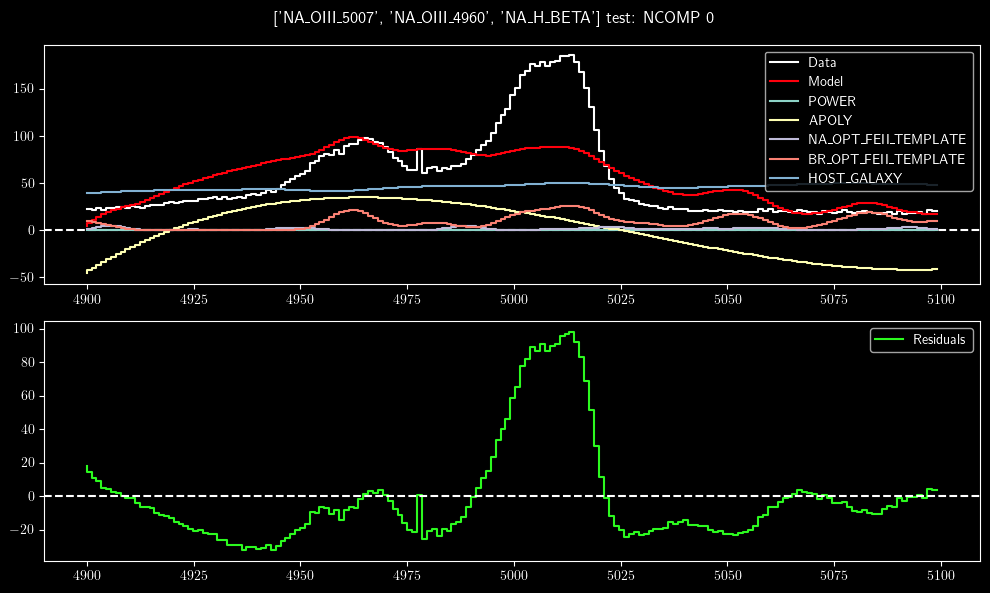

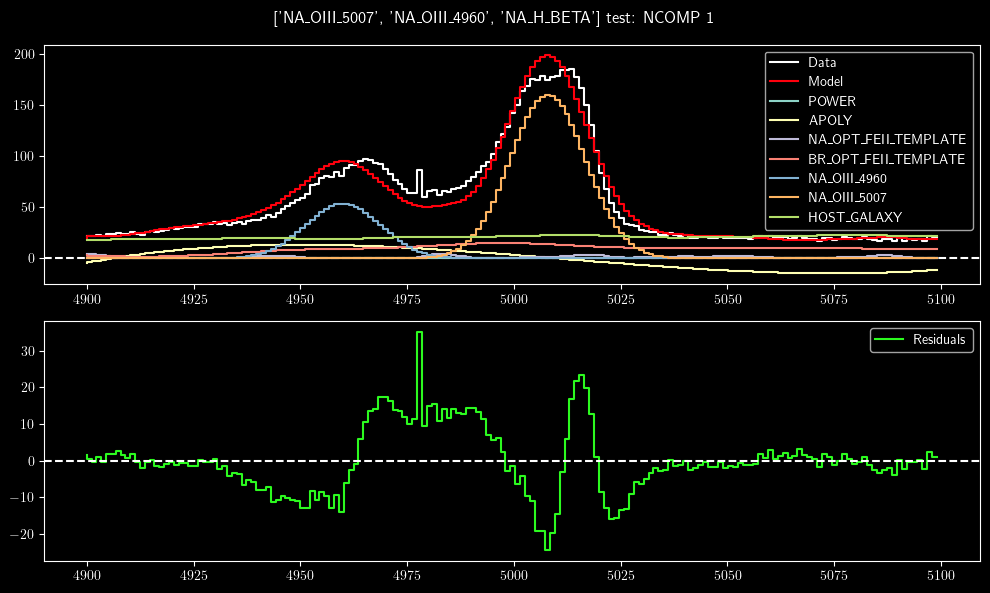

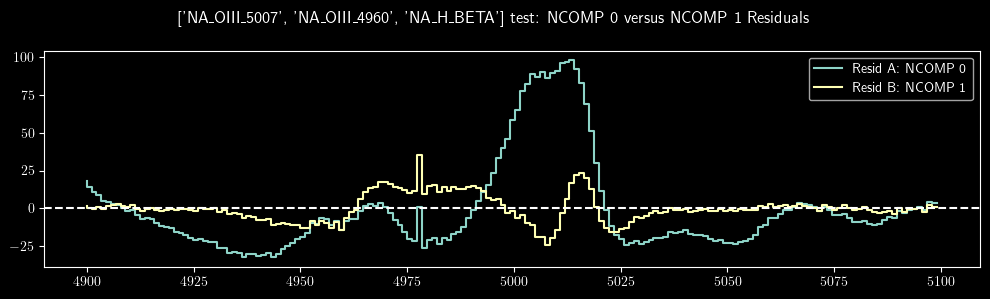

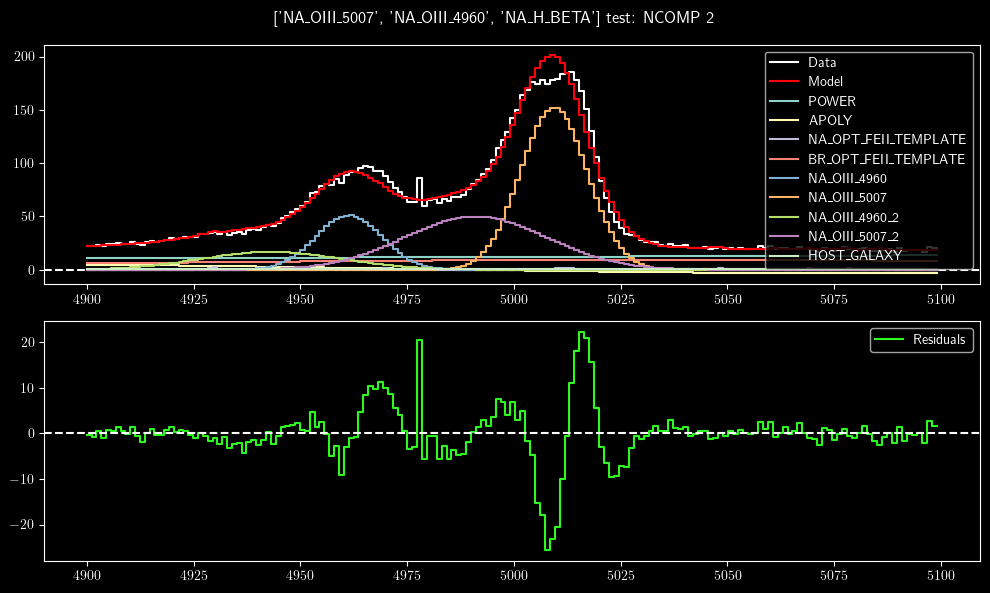

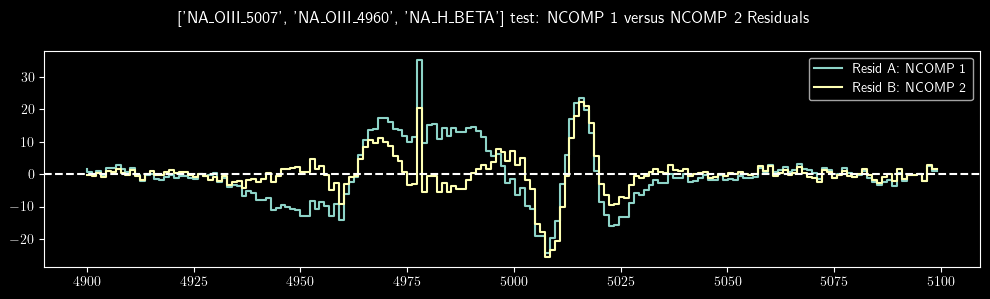

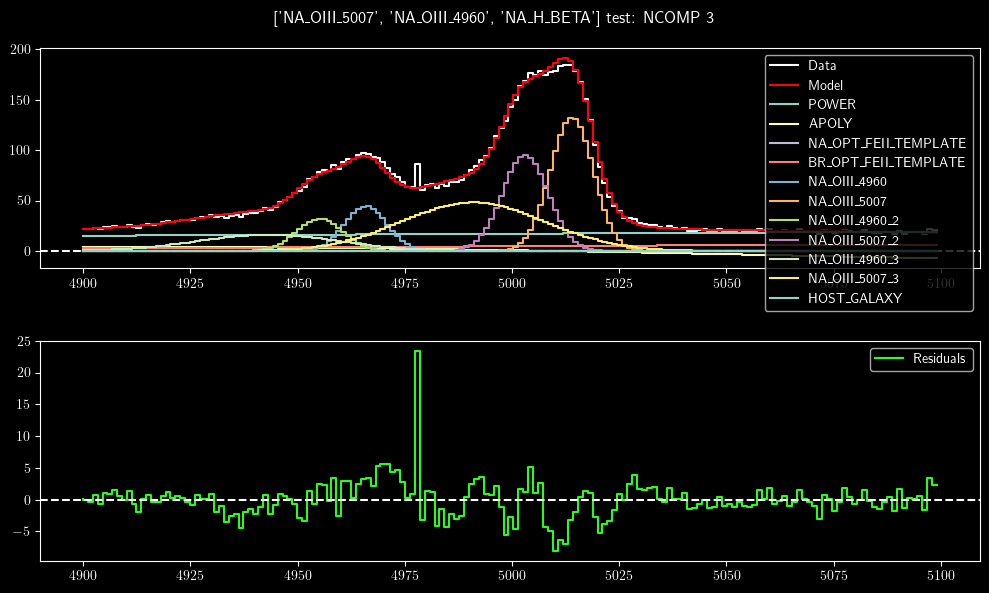

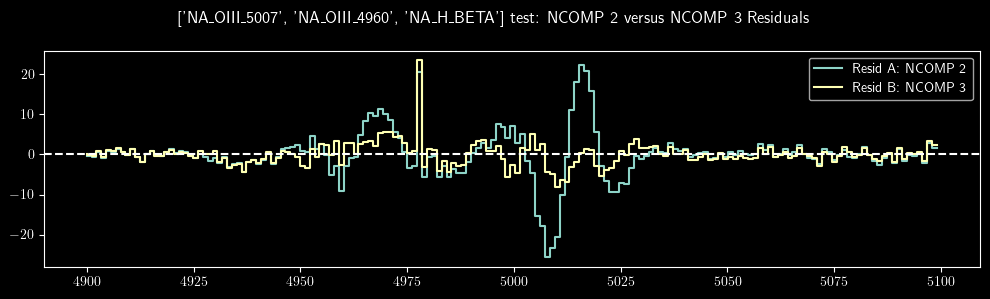

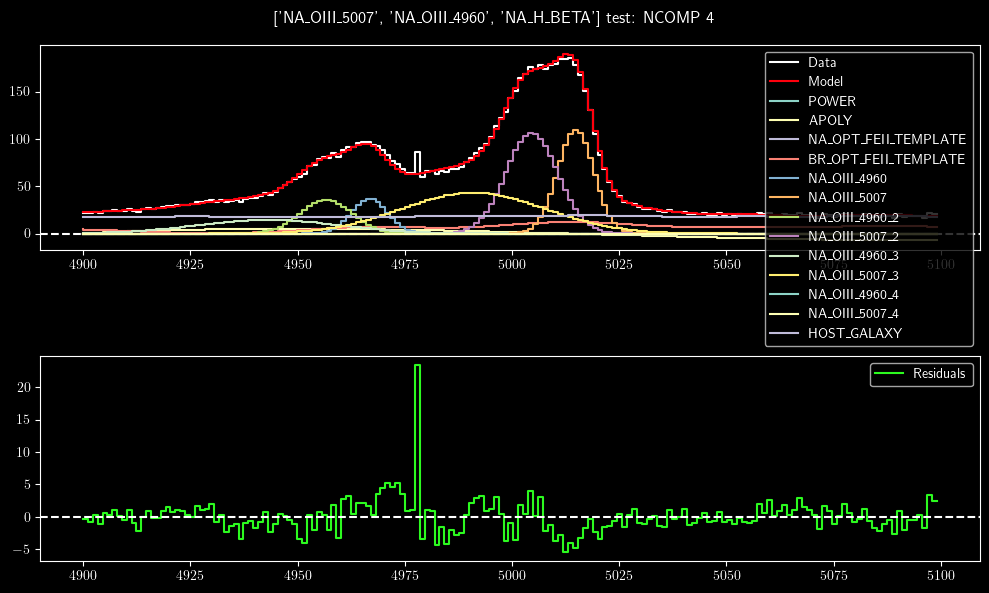

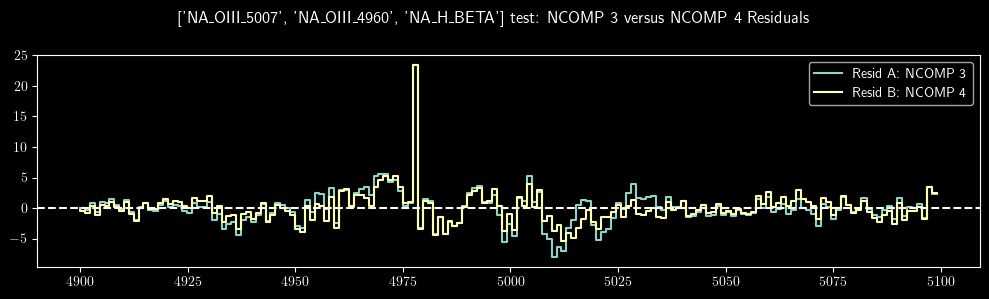

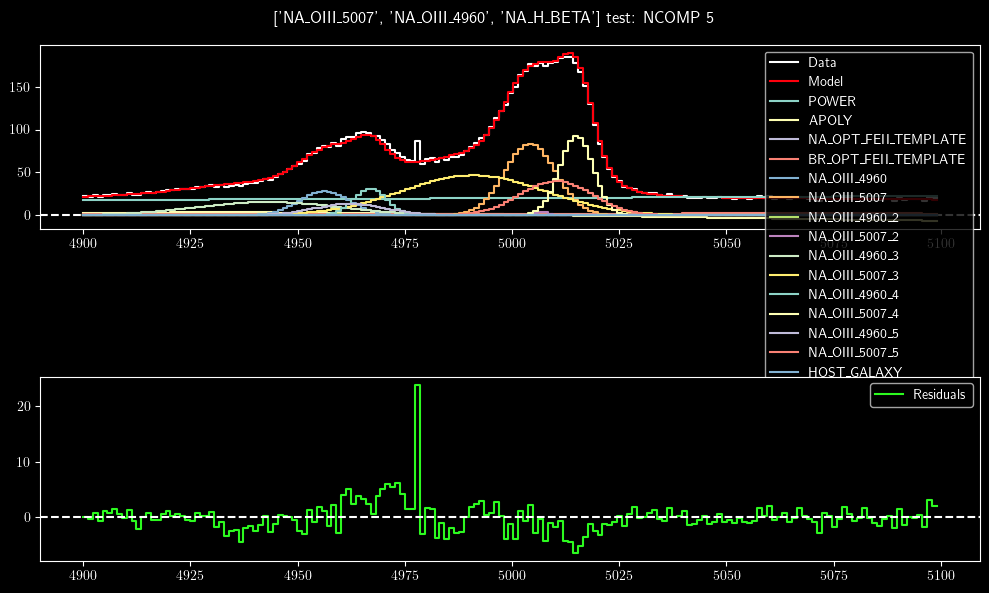

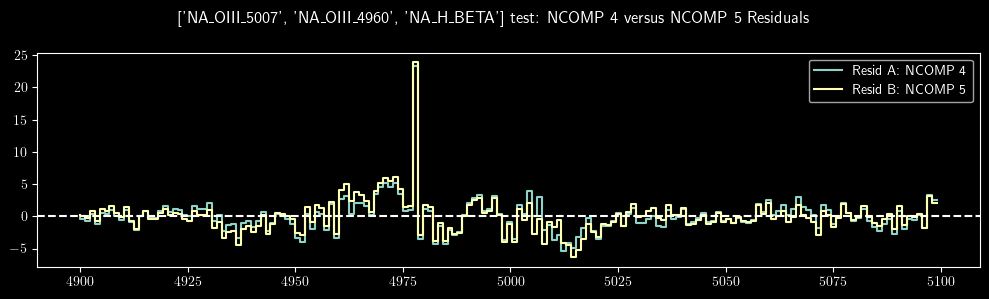

In [6]:
import importlib
importlib.reload(badass)
importlib.reload(badass_utils)
importlib.reload(badass_ncomp_options)



# Call the main function in BADASS
badass.run_BADASS(pathlib.Path(file),
                  options_file = options_file,
                 )
    #